In [1]:
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname=r'./res/NanumGothic.ttf', name='NanumGothic')                       
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) 

plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

In [3]:
path = './res/'

### 1. 장르

In [153]:
genre_gn_all = pd.read_json(path + 'genre_gn_all.json', typ = 'series')
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

In [61]:
genre_gn_all

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
...,...,...
249,GN2900,뮤지컬
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬
252,GN2903,국외뮤지컬


In [154]:
# 대분류 장르코드들만 뽑기
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:]=='00']
gnr_code

,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


In [63]:
len(gnr_code)

30

In [64]:
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\2070270742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)


In [65]:
dtl_gnr_code

,dtl_gnr_code,dtl_gnr_name
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-
...,...,...
247,GN2805,숙면유도
248,GN2806,반려동물
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬


In [66]:
len(dtl_gnr_code[dtl_gnr_code['dtl_gnr_name'] =='세부장르전체'])

27

In [67]:
dtl_gnr_code[dtl_gnr_code['dtl_gnr_name'] =='세부장르전체']

,dtl_gnr_code,dtl_gnr_name
1,GN0101,세부장르전체
7,GN0201,세부장르전체
13,GN0301,세부장르전체
19,GN0401,세부장르전체
23,GN0501,세부장르전체
33,GN0601,세부장르전체
40,GN0701,세부장르전체
51,GN0801,세부장르전체
57,GN0901,세부장르전체
66,GN1001,세부장르전체


In [68]:
# 앞자리 네 자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-
...,...,...,...,...
220,GN2800,뮤직테라피,GN2806,반려동물
221,GN2900,뮤지컬,GN2901,세부장르전체
222,GN2900,뮤지컬,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN2903,국외뮤지컬


In [69]:
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN2200']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
177,GN2200,어린이/태교,GN22,GN2201,유아동요
178,GN2200,어린이/태교,GN22,GN2202,창작동요
179,GN2200,어린이/태교,GN22,GN2203,영어동요
180,GN2200,어린이/태교,GN22,GN2204,영어동요
181,GN2200,어린이/태교,GN22,GN2205,영어동요
182,GN2200,어린이/태교,GN22,GN2206,영어동화
183,GN2200,어린이/태교,GN22,GN2207,만화
184,GN2200,어린이/태교,GN22,GN2208,자장가
185,GN2200,어린이/태교,GN22,GN2209,태교동화
186,GN2200,어린이/태교,GN22,GN2210,태교


In [70]:
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN2300']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
193,GN2300,종교음악,GN23,GN2301,가톨릭
194,GN2300,종교음악,GN23,GN2302,불교


In [71]:
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN3000']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
224,GN3000,크리스마스,GN30,NaN,NaN


In [58]:
gnr_code_tree[gnr_code_tree['dtl_gnr_code'].isna()]

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
224,GN3000,크리스마스,GN30,NaN,NaN


In [14]:
# 장르코드 파일 저장
gnr_code_tree.to_csv('./origin_data_modify/gnr_code_tree.csv', index=False)

In [72]:
gnr_code_tree = pd.read_csv('./origin_data_modify/gnr_code_tree.csv')
gnr_code_tree.head()

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN01,GN0101,세부장르전체
1,GN0100,발라드,GN01,GN0102,'80
2,GN0100,발라드,GN01,GN0103,'90
3,GN0100,발라드,GN01,GN0104,'00
4,GN0100,발라드,GN01,GN0105,'10-


In [78]:
gnr_code_tree.head()

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN01,GN0101,세부장르전체
1,GN0100,발라드,GN01,GN0102,'80
2,GN0100,발라드,GN01,GN0103,'90
3,GN0100,발라드,GN01,GN0104,'00
4,GN0100,발라드,GN01,GN0105,'10-


In [75]:
gnr_code_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gnr_code      225 non-null    object
 1   gnr_name      225 non-null    object
 2   join_code     225 non-null    object
 3   dtl_gnr_code  224 non-null    object
 4   dtl_gnr_name  224 non-null    object
dtypes: object(5)
memory usage: 8.9+ KB


In [77]:
gnr_code_tree.columns

Index(['gnr_code', 'gnr_name', 'join_code', 'dtl_gnr_code', 'dtl_gnr_name'], dtype='object')

### 2. song_meta

In [4]:
song_meta = pd.read_json(path + 'song_meta.json', typ = 'frame')
song_meta

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4
...,...,...,...,...,...,...,...,...,...
707984,[GN2001],19991219,The Best Best Of The Black President,65254,[166499],Coffin For Head Of State,[GN2000],[Fela Kuti],707984
707985,[GN0901],19860000,True Colors,44141,[11837],Change Of Heart,[GN0900],[Cyndi Lauper],707985
707986,"[GN0105, GN0101]",20160120,행보 2015 윤종신 / 작사가 윤종신 Live Part.1,2662866,[437],스치듯 안녕,[GN0100],[윤종신],707986
707987,"[GN1807, GN1801]",20131217,명상의 시간을 위한 뉴에이지 음악,2221722,[729868],숲의 빛,[GN1800],[Nature Piano],707987


In [7]:
song_meta[song_meta['issue_date'] >= 20200500]['issue_date']

Series([], Name: issue_date, dtype: int64)

In [6]:
# 'issue_date' 값을 변경할 행의 인덱스를 가져옵니다.
indices_to_update = [141185, 448286]  # 변경하려는 행의 인덱스 목록

# 'issue_date' 값을 변경할 값으로 설정합니다.
new_value = 20200113

# 특정 행의 'issue_date' 값을 변경합니다.
for idx in indices_to_update:
    song_meta.at[idx, 'issue_date'] = new_value

In [8]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

In [9]:
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [10]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

# 3. 2번 테이블에 비율 값 추가
gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.69
1,2,92378,13.07
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


In [11]:
song_gnr_rate = gnr_song_count['비율(%)']
song_gnr_rate

0    86.69
1    13.07
2     0.24
3     0.01
4     0.00
5     0.00
Name: 비율(%), dtype: float64

(-1.099999828471832,
 1.0999999626802759,
 -1.0999999295257554,
 1.0999999966440837)

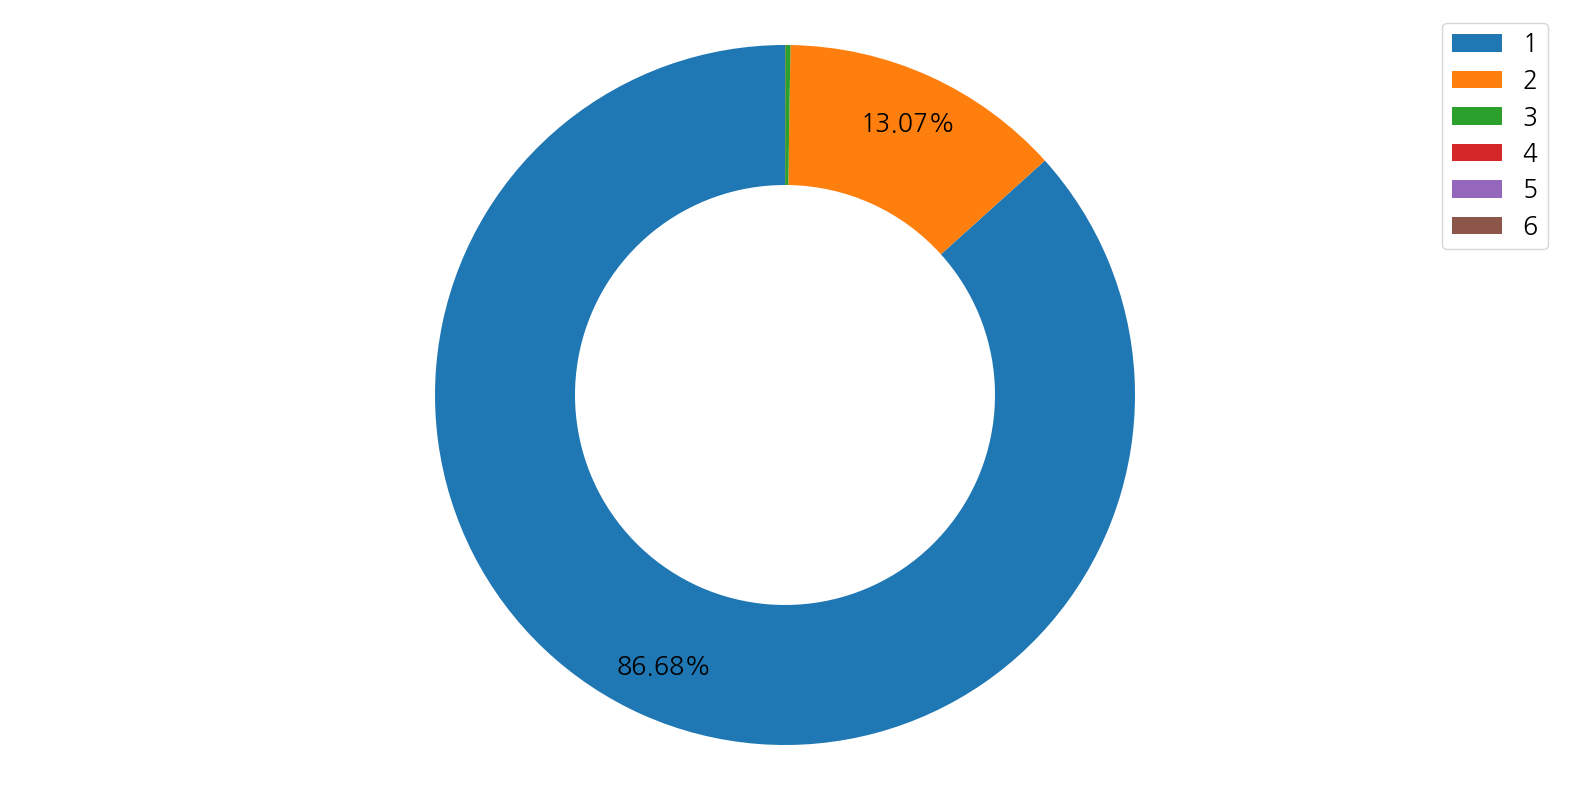

In [159]:
wed = {"width": 0.4}
plt.pie(song_gnr_rate, labels=None, wedgeprops=wed, startangle=90, autopct=lambda p: '{:.2f}%'.format(p) if p > 2 else '', pctdistance=0.85)

# 라벨 추가
plt.legend(genre_counts, loc='upper right')

plt.axis('equal')

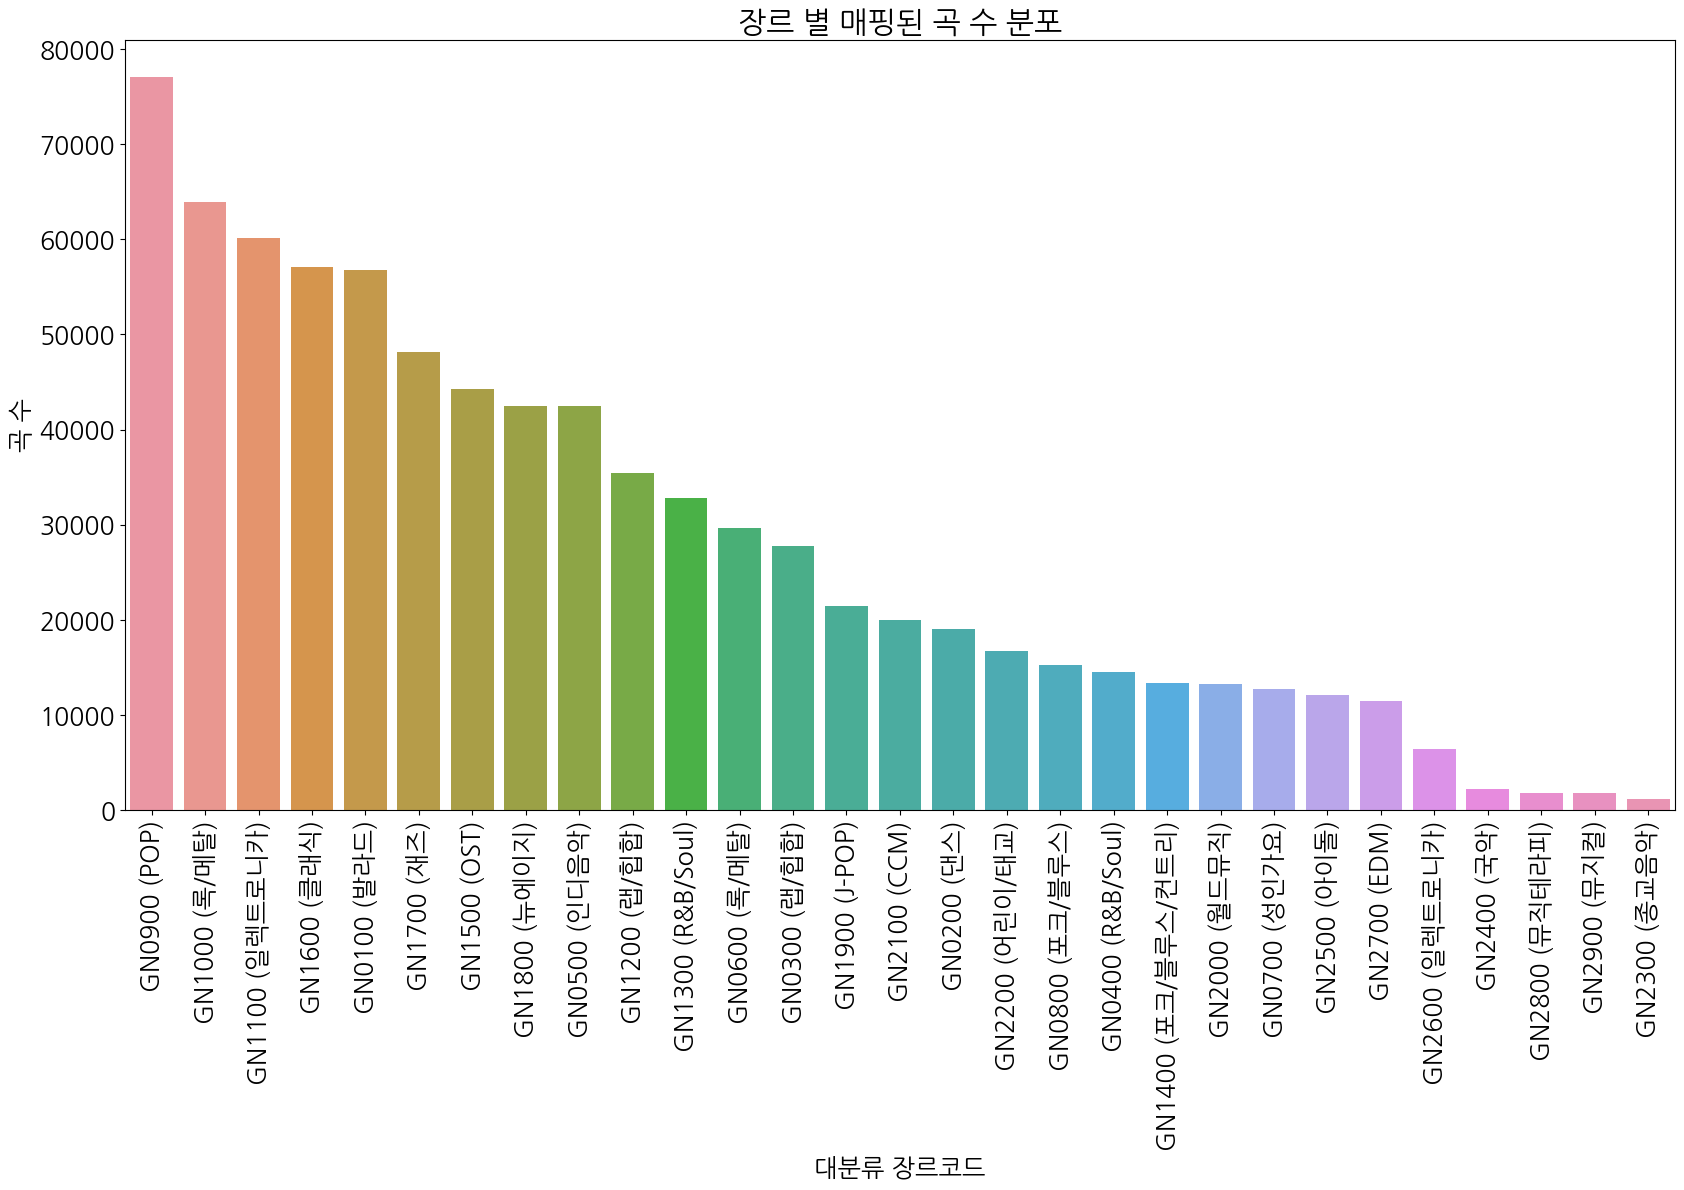

In [154]:
# 가장 많이 매핑되는 장르

gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')

# 2. 1번 테이블과 장르 meta와 join
gnr_count = pd.merge(gnr_count, gnr_code.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'

# 3. 매핑이 되지 않은 일부 곡들은 제거
gnr_count = gnr_count[['gnr_code_name', 'song_cnt']].dropna()

# 4. 많은 곡이 매핑된 순 기준으로 내림차순 리스트 생성
gnr_list_desc = gnr_count.sort_values('song_cnt', ascending = False).gnr_code_name

# 5. plotting
gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = gnr_count, order = gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# 발매 년도 별 곡 비중

# 이상치 수정
# 'issue_date' 값을 변경할 행의 인덱스를 가져옵니다.
indices_to_update = [141185, 448286]  # 변경하려는 행의 인덱스 목록

# 'issue_date' 값을 변경할 값으로 설정합니다.
new_value = 20200113

# 특정 행의 'issue_date' 값을 변경합니다.
for idx in indices_to_update:
    song_meta.at[idx, 'issue_date'] = new_value

song_meta.to_csv('./origin_data_modify/song_meta.csv', index=False)

C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\3464494275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)
C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\3464494275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\3464494275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

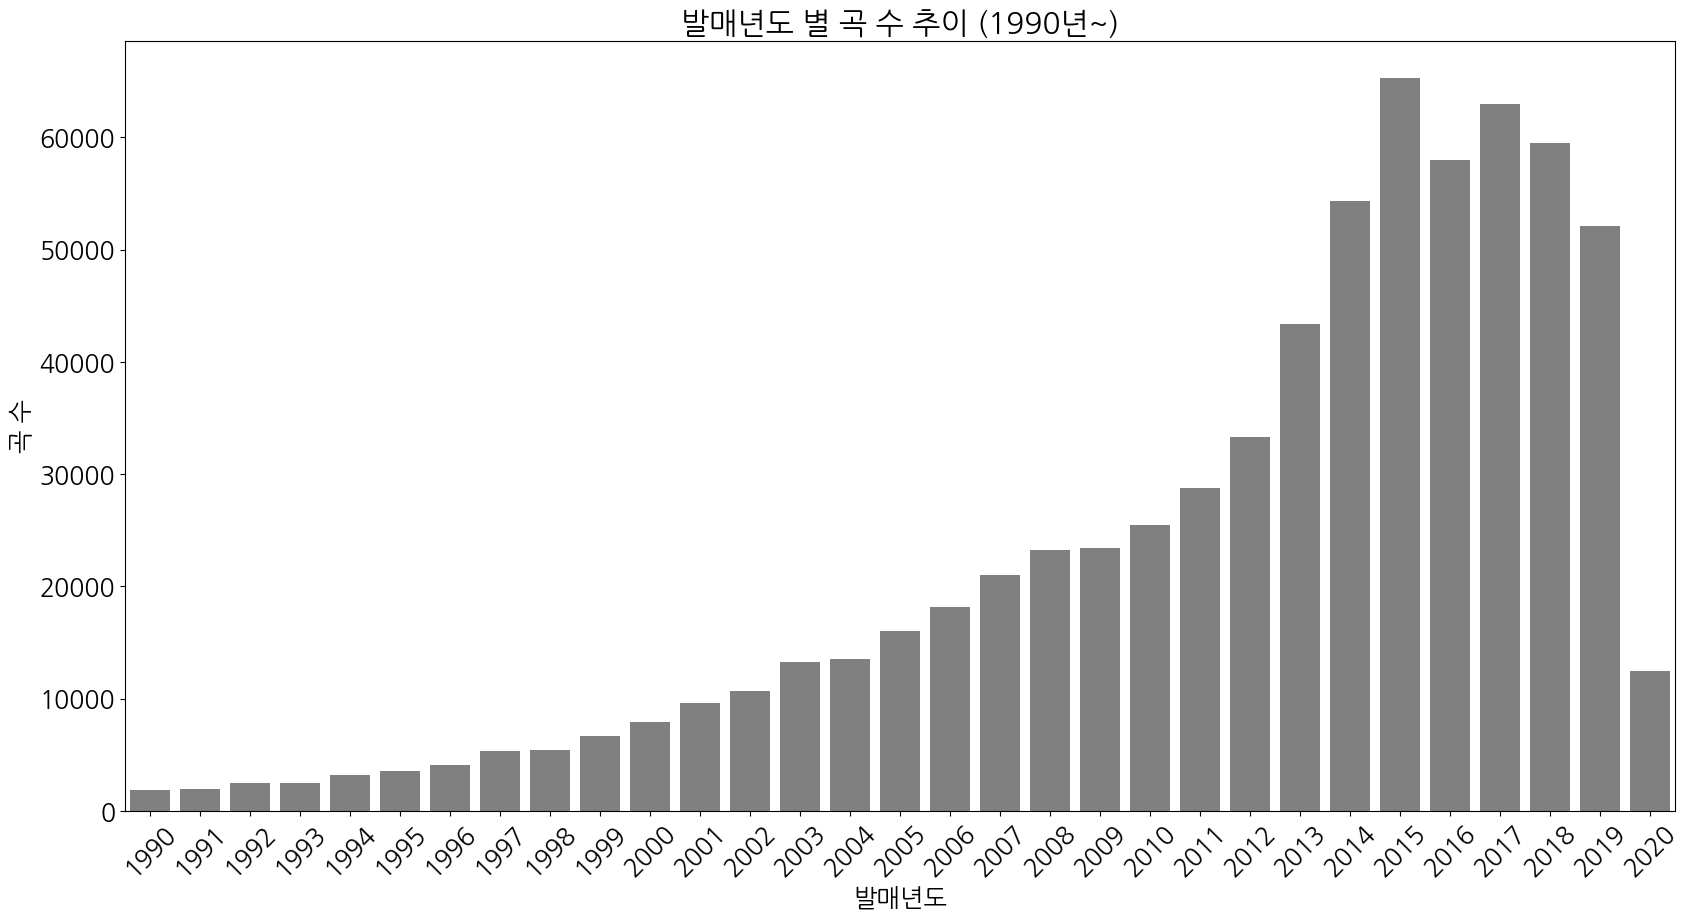

In [14]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

# 3. 1990년도~ 필터링
song_issue_date_filter = song_issue_date[song_issue_date.issue_year >= '1990']

# 4. 발매년도 별 곡 수 count 테이블 생성 : issue_year_song_cnt
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')

# 5. plotting
issue_year_song_cnt_plot = sns.barplot(x = 'issue_year', y = 'song_cnt', data = issue_year_song_cnt, color = 'grey')
issue_year_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_year_song_cnt_plot.set_xlabel('발매년도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation = 45)
plt.show()

In [15]:
song_issue_date

,song_id,issue_date,issue_year
0,0,20140512,2014
1,1,20080421,2008
2,2,20180518,2018
3,3,20151016,2015
4,4,20110824,2011
...,...,...,...
707984,707984,19991219,1999
707985,707985,19860000,1986
707986,707986,20160120,2016
707987,707987,20131217,2013


In [26]:
song_issue_date[song_issue_date['issue_year']==0]

,song_id,issue_date,issue_year


In [32]:
song_issue_data_cnt = song_issue_date.groupby('issue_year')['song_id'].count().reset_index()
song_issue_data_cnt

,issue_year,song_id
0,0,2795
1,1900,12
2,1919,4
3,1927,5
4,1931,1
...,...,...
78,2016,58016
79,2017,63008
80,2018,59489
81,2019,52119


In [34]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

song_issue_date

C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\3271010862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)
C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\3271010862.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\3271010862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,song_id,issue_date,issue_year
0,0,20140512,2014
1,1,20080421,2008
2,2,20180518,2018
3,3,20151016,2015
4,4,20110824,2011
...,...,...,...
707984,707984,19991219,1999
707985,707985,19860000,1986
707986,707986,20160120,2016
707987,707987,20131217,2013


In [37]:
song_issue_date[song_issue_date['issue_year'] == '0']

,song_id,issue_date,issue_year
562,562,0,0
785,785,0,0
1543,1543,0,0
1730,1730,0,0
2360,2360,0,0
...,...,...,...
707473,707473,0,0
707483,707483,0,0
707515,707515,0,0
707738,707738,0,0


In [53]:
song_issue_date_cnt = song_issue_date.groupby('issue_year')['song_id'].count().reset_index()
old_song_cnt = song_issue_date_cnt[song_issue_date_cnt['issue_year'] < '1990']
old_song_cnt

,issue_year,song_id
0,0,2795
1,1900,12
2,1919,4
3,1927,5
4,1931,1
5,1936,4
6,1939,3
7,1941,8
8,1945,17
9,1946,3


In [54]:
old_song_cnt['song_id'].sum()

18248

In [65]:
young_song_cnt = song_issue_date_cnt[song_issue_date_cnt['issue_year'] >= '1990']
young_song_cnt

,issue_year,song_id
52,1990,1836
53,1991,1941
54,1992,2496
55,1993,2532
56,1994,3191
57,1995,3594
58,1996,4105
59,1997,5335
60,1998,5404
61,1999,6719


In [56]:
young_song_cnt['song_id'].sum()

689741

In [59]:
# 18248 / (18248+689741)*100 # 2.57%
2795 / (18248+689741)*100

0.3947801448892567

In [69]:
young_song_cnt.reset_index(drop=True)

,issue_year,song_id
0,1990,1836
1,1991,1941
2,1992,2496
3,1993,2532
4,1994,3191
5,1995,3594
6,1996,4105
7,1997,5335
8,1998,5404
9,1999,6719


In [72]:
young_song_cnt['song_id'].sum()

689741

In [71]:
young_song_cnt.iloc[24:30, :]['song_id'].sum()

352251

In [73]:
352251/689741*100

51.07003933360493

In [42]:
problem_issue_date = song_meta[song_meta['issue_date']==0]
problem_issue_date

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
562,"[GN0906, GN0901]",0,MTV Unplugged,65244,[2350],Summer Of `69,[GN0900],[Bryan Adams],562
785,[GN1801],0,The Letter,8177,[101554],기다림 (Missing You),[GN1800],[안단테],785
1543,[GN0701],0,한국(韓國) 최고가수(最高歌手) 36인 여자가수편(女子歌手篇),30431,[40],만남,[GN0700],[노사연],1543
1730,"[GN1013, GN0901, GN0902, GN1001]",0,Bury The Hatchet: The Complete Sessions,22367,[100250],Promises,"[GN0900, GN1000]",[Cranberries],1730
2360,"[GN1006, GN1005, GN1013, GN1001]",0,The House Of Blue Light,65732,[103794],Hard Lovin&#39; Woman,[GN1000],[Deep Purple],2360
...,...,...,...,...,...,...,...,...,...
707473,[GN1701],0,Reckless Precision,35135,[2315],Man In The Mirror,[GN1700],[Tuck Andress],707473
707483,[GN1701],0,Godchild,130164,[3658],Bag`s Groove,[GN1700],[Miles Davis],707483
707515,[GN1701],0,Reckless Precision,35135,[2315],(Somewhere) Over The Rainbow/If I Only Had A B...,[GN1700],[Tuck Andress],707515
707738,[GN0701],0,은방울자매 전곡 BEST HIT,315093,[100050],마포 종점,[GN0700],[은방울 자매],707738


### 3. train

In [74]:
train = pd.read_json(path + 'train.json', typ = 'frame')
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [76]:
train.info()
train.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


Index(['tags', 'id', 'plylst_title', 'songs', 'like_cnt', 'updt_date'], dtype='object')

In [77]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = train[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# unnest 객체 제거
del plylst_song_map_unnest

plylst_song_map

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861
...,...,...
5285866,100389,111365
5285867,100389,51373
5285868,100389,640239
5285869,100389,13759


In [78]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

plylst_tag_map

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


In [79]:
train_uniq_song_cnt = plylst_song_map.songs.nunique() # 유니크 곡 수
train_uniq_tag_cnt = plylst_tag_map.tags.nunique() # 유니크 태그 수

print('곡 수 : %s' %train_uniq_song_cnt)
print('태그 수 : %s' %train_uniq_tag_cnt)

곡 수 : 615142
태그 수 : 29160


- 플레이리스트 별 곡/태그/장르 수 분포는?
    - 수록곡

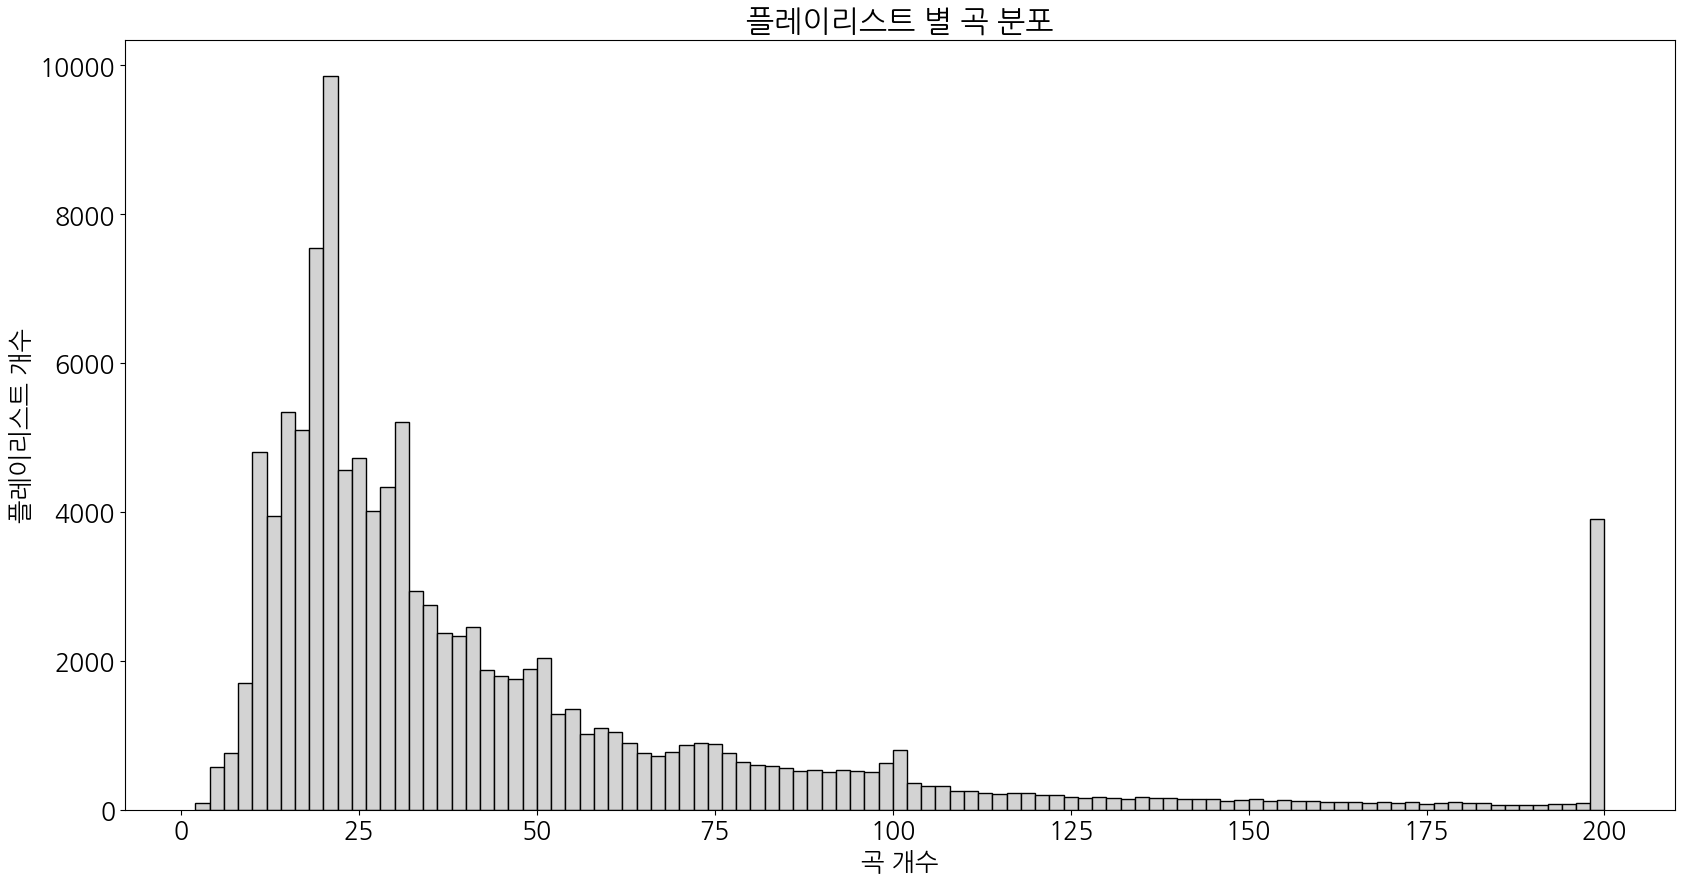

In [87]:
# 1. 플레이리스트 별 수록곡 수 count 테이블 생성 : plylst_song_cnt
plylst_song_cnt = pd.DataFrame(plylst_song_map.groupby('id').songs.nunique())

# 2-1. grid setting
grid_list = [i*2 for i in range(1, 101)]

# 2-2. plotting
plt.hist(plylst_song_cnt['songs'], grid_list, color = "lightgrey", edgecolor = "black")
plt.xlabel('곡 개수')
plt.ylabel('플레이리스트 개수')
plt.title('플레이리스트 별 곡 분포')
plt.show()

In [83]:
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000


In [84]:
train['songs_cnt'] = train['songs'].apply(lambda x : len(x))
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,songs_cnt
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,19
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,42
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,28
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,38
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,53


In [88]:
train[train['songs_cnt']==200]

,tags,id,plylst_title,songs,like_cnt,updt_date,songs_cnt
42,"[80년대, 감성, 90년대발라드, 올드송, 추억, 휴식, 90년대, 옛날노래]",131098,8~90년대 우리나라 라디오에서 흘러나오던 명곡들.,"[88935, 82330, 405668, 324208, 436057, 106214,...",53,2019-11-25 17:25:12.000,200
90,"[조용한, 밤, 새벽]",8455,혼자남겨진밤..,"[491985, 411735, 610933, 44200, 454979, 682575...",0,2017-07-25 19:45:23.000,200
177,"[힙합, 랩, 오승훈, GZ, 신나는]",80395,#어디가서 힙알못 소리는 듣지말자 (해외),"[374511, 706915, 163606, 557613, 116795, 15305...",1730,2020-04-22 03:02:38.000,200
186,"[빠른비트, 신나는노래, 댄스곡, 힘들때, 운동할때]",31654,운동 중에 들으면 힘나는 빠른 댄스곡!!,"[664562, 213846, 644076, 626654, 263559, 49864...",657,2020-04-23 17:09:10.000,200
246,[발라드],114074,힘들때 마음편히들을수있는 발라드,"[251375, 191709, 569548, 553285, 47711, 445337...",12,2015-09-14 16:58:48.000,200
...,...,...,...,...,...,...,...
114903,"[새벽감성, 잔잔한노래, 뉴에이지, 새벽에듣기좋은노래]",65082,밤과 새벽 사이,"[352313, 85278, 448698, 593128, 595181, 253755...",102,2020-04-20 02:21:16.000,200
114948,"[추억, 기분전환, 회상]",113033,알짜배기만 모았다,"[164067, 323755, 290622, 594088, 623423, 27668...",2,2014-09-18 18:59:32.000,200
115009,[우울할때],83080,취향저격 발라드,"[571100, 514321, 74690, 264505, 47119, 541419,...",33,2016-08-04 02:52:11.000,200
115017,"[드라이브, 기분전환]",17162,오늘의 추천 가수 - 애즈원,"[392503, 363533, 492623, 668400, 536657, 32048...",10,2018-09-27 15:24:51.000,200


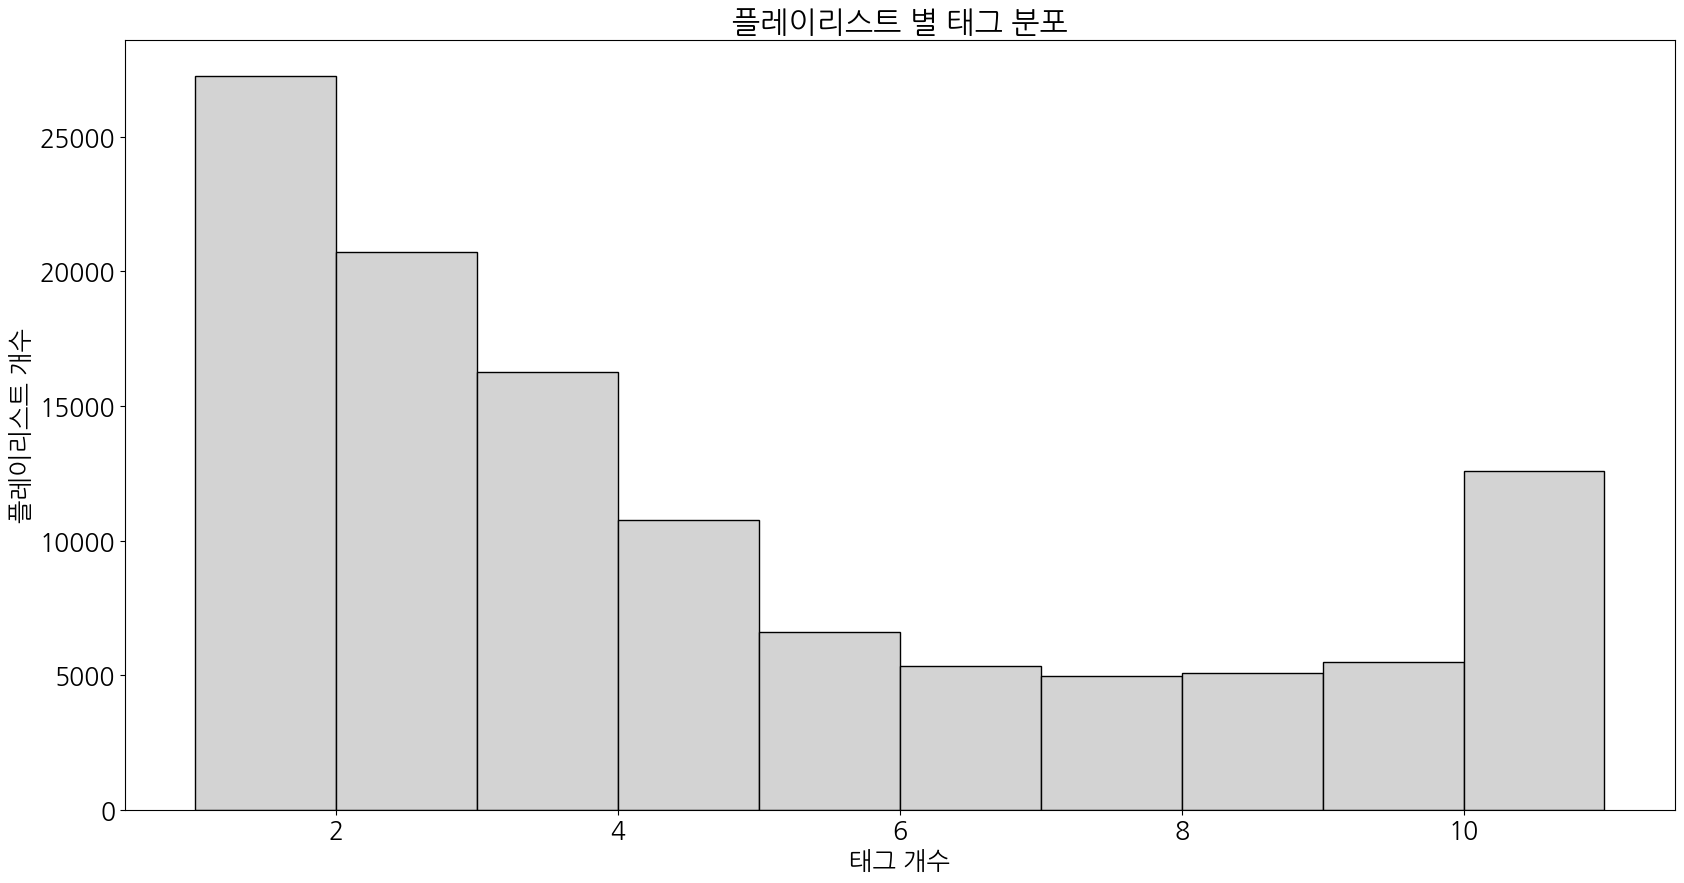

In [89]:
# 1. 플레이리스트 별 매핑 태그 수 count 테이블 생성 : plylst_tag_cnt
plylst_tag_cnt = pd.DataFrame(plylst_tag_map.groupby('id').tags.nunique())

# 2. plotting
plt.hist(plylst_tag_cnt['tags'], range(1, 12), color = "lightgrey", edgecolor = "black")
plt.xlabel('태그 개수')
plt.ylabel('플레이리스트 개수')
plt.title('플레이리스트 별 태그 분포')
plt.show()

In [102]:
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,songs_cnt
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,19
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,42
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,28
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,38
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,53


In [104]:
train_tag_cnt = train[['id', 'tags']]
train_tag_cnt

,id,tags
0,61281,[락]
1,10532,"[추억, 회상]"
2,76951,"[까페, 잔잔한]"
3,147456,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,..."
4,27616,[댄스]
...,...,...
115066,120325,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]"
115067,106976,[일렉]
115068,11343,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]"
115069,131982,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]"


In [105]:
train_tag_cnt['tag_cnt'] = train_tag_cnt['tags'].apply(lambda x : len(x))
train_tag_cnt

C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\13749474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tag_cnt['tag_cnt'] = train_tag_cnt['tags'].apply(lambda x : len(x))


,id,tags,tag_cnt
0,61281,[락],1
1,10532,"[추억, 회상]",2
2,76951,"[까페, 잔잔한]",2
3,147456,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",10
4,27616,[댄스],1
...,...,...,...
115066,120325,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",7
115067,106976,[일렉],1
115068,11343,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",8
115069,131982,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",6


In [111]:
train_tag_cnt = train_tag_cnt.groupby('tag_cnt')['id'].count().reset_index()
train_tag_cnt

,tag_cnt,id
0,1,27242
1,2,20725
2,3,16245
3,4,10770
4,5,6613
5,6,5351
6,7,4986
7,8,5080
8,9,5484
9,10,12570


In [112]:
train_tag_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   tag_cnt  11 non-null     int64
 1   id       11 non-null     int64
dtypes: int64(2)
memory usage: 308.0 bytes


In [115]:
train_tag_cnt['tag_cnt_rate'] = train_tag_cnt['id'].apply(lambda x : x/sum(train_tag_cnt['id'])*100)

In [116]:
train_tag_cnt

,tag_cnt,id,tag_cnt_rate
0,1,27242,23.674079
1,2,20725,18.010620
2,3,16245,14.117371
3,4,10770,9.359439
4,5,6613,5.746887
5,6,5351,4.650173
6,7,4986,4.332977
7,8,5080,4.414666
8,9,5484,4.765753
9,10,12570,10.923691


(-1.0999994672159232,
 1.0999999741454027,
 -1.0999998041877093,
 1.0999999906756053)

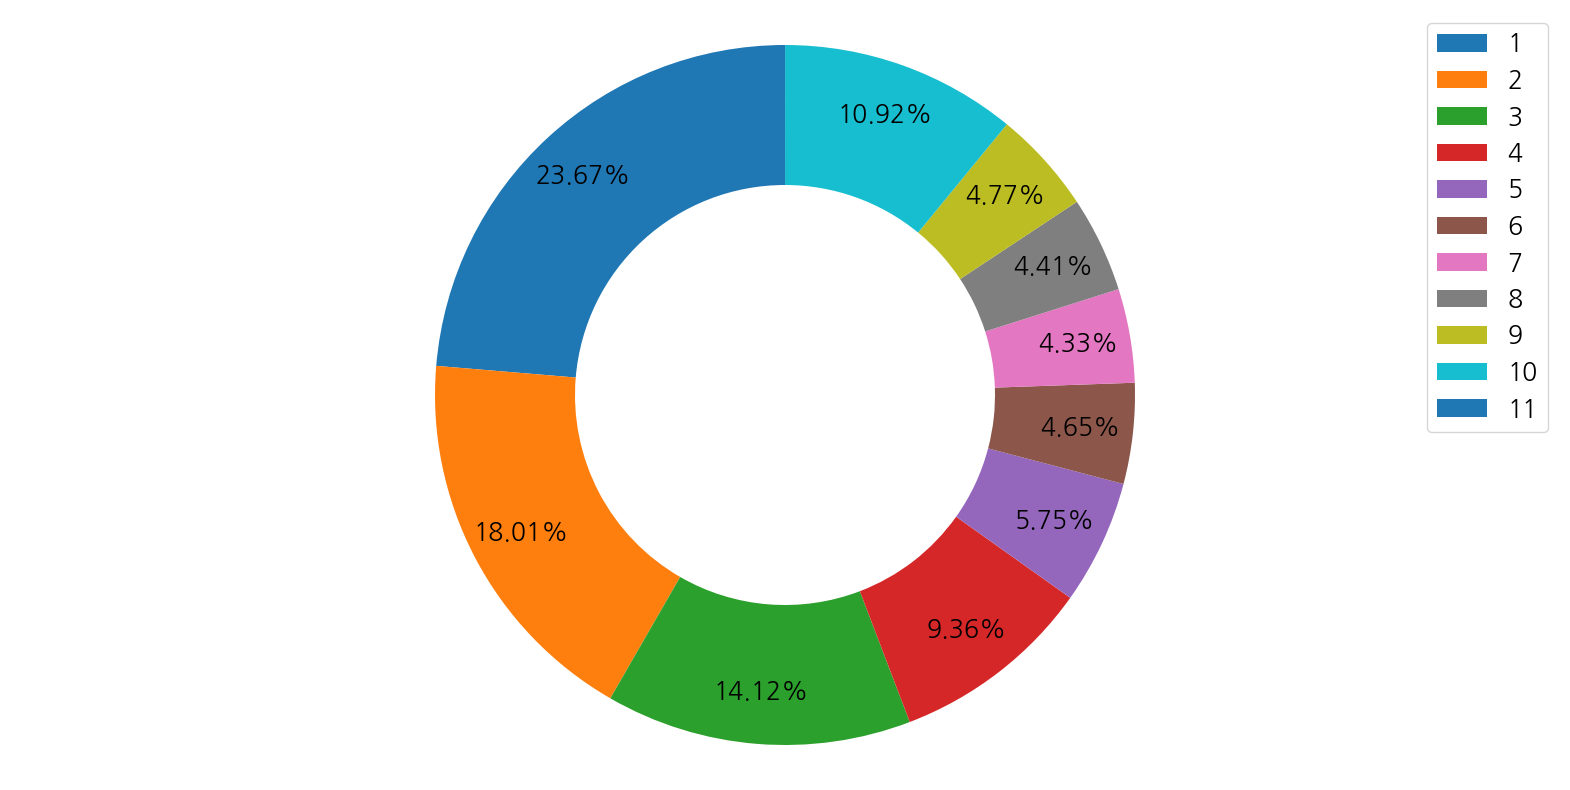

In [121]:
train_tag_cnt_x = list(train_tag_cnt['tag_cnt_rate'])
tag_cnt_legend = list(train_tag_cnt['tag_cnt'])

wed = {"width": 0.4}
plt.pie(train_tag_cnt_x, labels=None, wedgeprops=wed, startangle=90, autopct=lambda p: '{:.2f}%'.format(p) if p > 2 else '', pctdistance=0.85)

# 라벨 추가
plt.legend(tag_cnt_legend, loc='upper right')

plt.axis('equal')

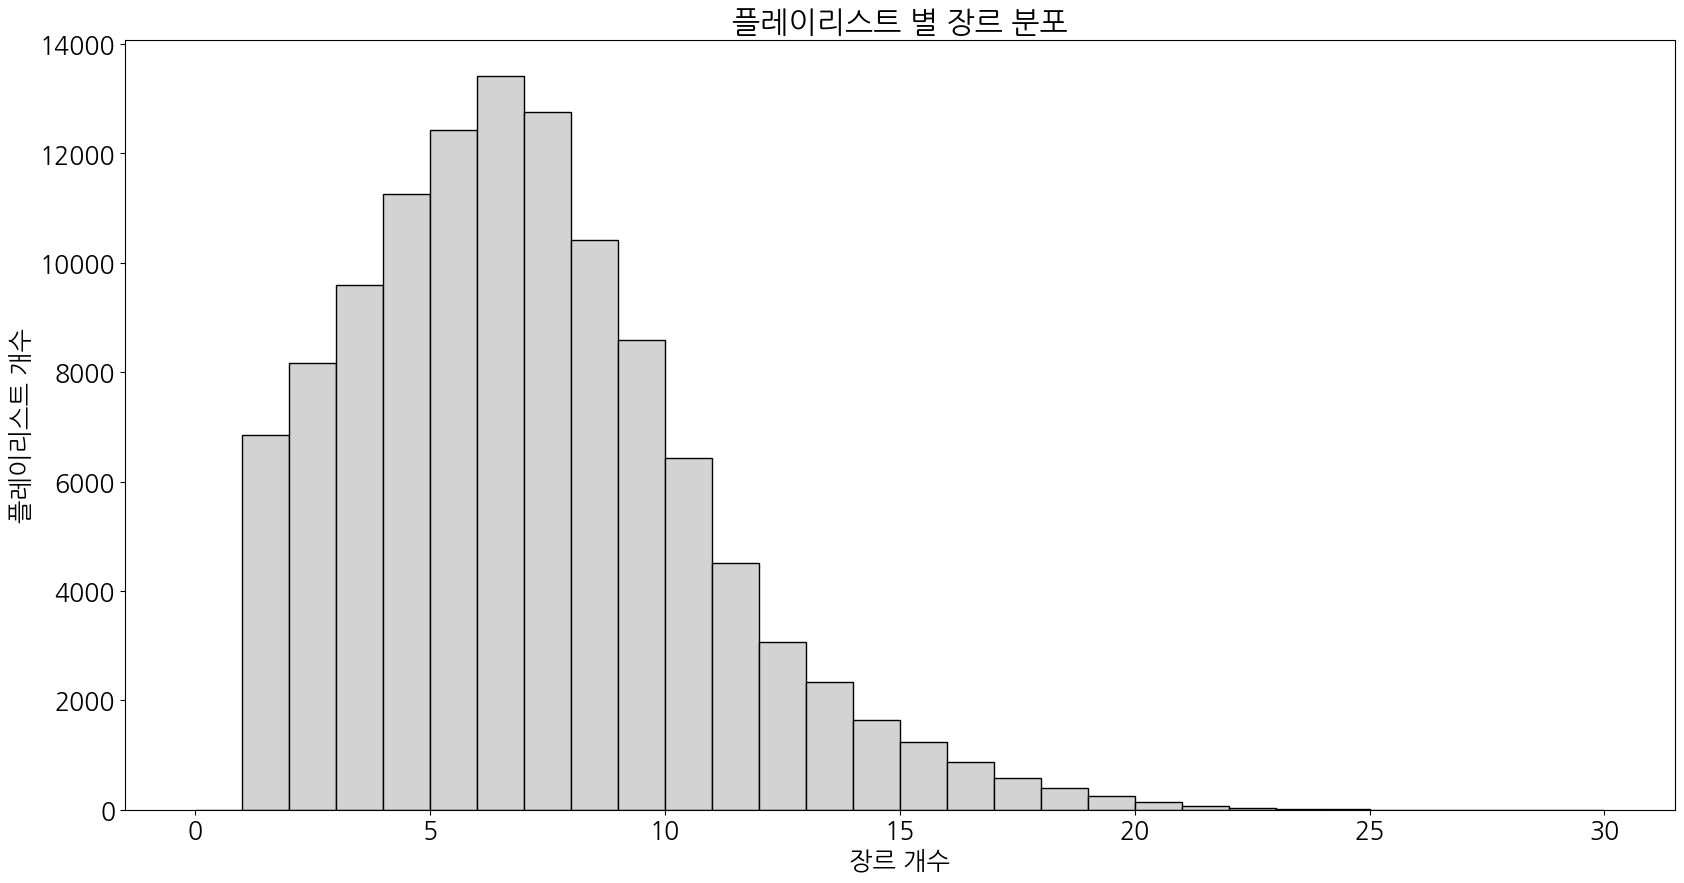

In [91]:
# 1-1. join 목적으로 곡 아이디 integer to string 변환
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# 1-2. 플레이리스트-곡 테이블 plylst_song_map + 곡-장르 테이블 song_gnr_map join
plylst_song_gnr_map = pd.merge(plylst_song_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 2. 플레이리스트 별 곡 장르 수 count 테이블 생성 : plylst_song_gnr_cnt
plylst_song_gnr_cnt = pd.DataFrame(plylst_song_gnr_map.groupby('id').gnr_code.nunique())

# 3. plotting
plt.hist(plylst_song_gnr_cnt['gnr_code'], range(0, 31), color = "lightgrey", edgecolor = "black")
plt.xlabel('장르 개수')
plt.ylabel('플레이리스트 개수')
plt.title('플레이리스트 별 장르 분포')
plt.show()

- 곡/태그/플레이리스명 중복 비율은?
    - 중복 수록곡 비중

In [123]:
plylst_song_map

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861
...,...,...
5285866,100389,111365
5285867,100389,51373
5285868,100389,640239
5285869,100389,13759


In [122]:
# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 수록 구분 : 곡 별 수록된 플레이리스트가 한 개면 '단일 수록', 두 개 이상이면 '중복 수록'
song_plylst_cnt = song_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(song_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 수록', '중복 수록'])
)

# 3. 단일/중복 수록 구분 별 곡 수 count 테이블 생성 : song_plylst_mapping_division
song_plylst_mapping_division = pd.DataFrame(song_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
song_plylst_mapping_division.rename(columns = {'songs' : '곡 수'}, inplace = True)
song_plylst_mapping_division.loc[:, '비율(%)'] = round(song_plylst_mapping_division['곡 수']/sum(song_plylst_mapping_division['곡 수'])*100, 2)
song_plylst_mapping_division = song_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 수록 여부'})
song_plylst_mapping_division[['중복 수록 여부', '곡 수', '비율(%)']]

,중복 수록 여부,곡 수,비율(%)
0,단일 수록,299028,48.61
1,중복 수록,316114,51.39


In [131]:
# 1. song_plylst_cnt 테이블에서 중복 수록 곡 중 수록 횟수 기준 상위 30곡 필터링 테이블 생성 : duplicate_song_top30
duplicate_song_top30 = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '중복 수록'].nlargest(30, 'mapping_plylst_cnt')

# 2-1. join 목적으로 곡 아이디 integer to string 변환
duplicate_song_top30['songs'] = duplicate_song_top30['songs'].astype(str)
song_meta['id'] = song_meta['id'].astype(str)

# 2-2 상위 30곡 테이블 duplicate_song_top30 + 곡 메타 song_meta join
top_30 = pd.merge(duplicate_song_top30, song_meta[['id', 'song_name', 'artist_name_basket']],how = 'left', left_on = 'songs', right_on = 'id')[['songs', 'song_name', 'artist_name_basket', 'mapping_plylst_cnt']].rename(columns = {'songs' : '곡 아이디', 'song_name' : '곡 명', 'artist_name_basket' : '아티스트 명', 'mapping_plylst_cnt' : '수록 횟수'})

In [134]:
top_30

,곡 아이디,곡 명,아티스트 명,수록 횟수
0,144663,밤편지,[아이유],2175
1,116573,안아줘,[정준일],2121
2,357367,비,[폴킴],1981
3,366786,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],1919
4,654757,눈의 꽃,[박효신],1647
5,133143,"그대와 나, 설레임 (Feat. 소울맨)",[어쿠스틱 콜라보],1633
6,349492,어떤이별,[임승부],1599
7,675115,야생화,[박효신],1598
8,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)],1544
9,42155,벙어리,[홍아],1540


In [140]:
genre_gn_all = pd.read_json(path + 'genre_gn_all.json', typ = 'series')
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

In [141]:
# 1. song_plylst_cnt 테이블에서 단일 수록 곡만 필터링 하여 테이블 생성 : single_song
single_song = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '단일 수록']

# 2-1. join 목적으로 곡 아이디 integer to string 변환
single_song['songs'] = single_song['songs'].astype(str)

# 2-2. 단일 수록 곡 테이블 single_song + 곡 메타 song_meta join : 아티스트 기준 single_song_artist, 장르 기준 single_song_gnr
single_song_artist = pd.merge(single_song, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
single_song_gnr = pd.merge(single_song, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 수록 곡 개수 기준 상위 30개 장르 : single_song_gnr_cnt
single_song_gnr_cnt = single_song_gnr.groupby('gnr_code').songs.nunique().reset_index(name = 'song_cnt')
single_top30 = pd.merge(single_song_gnr_cnt, genre_gn_all, how = 'left', on = 'gnr_code')[['gnr_code', 'gnr_name', 'song_cnt']].rename(columns = {'gnr_code' : '대분류 장르코드', 'gnr_name' : '장르명', 'song_cnt' : '수록 곡 수'}).sort_values('수록 곡 수', ascending = False)

C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\97784030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_song['songs'] = single_song['songs'].astype(str)


In [142]:
single_top30

,대분류 장르코드,장르명,수록 곡 수
15,GN1600,클래식,32841
8,GN0900,POP,30987
9,GN1000,록/메탈,30028
10,GN1100,일렉트로니카,25725
16,GN1700,재즈,23158
17,GN1800,뉴에이지,19370
14,GN1500,OST,16855
11,GN1200,랩/힙합,15054
0,GN0100,발라드,14575
12,GN1300,R&B/Soul,13136


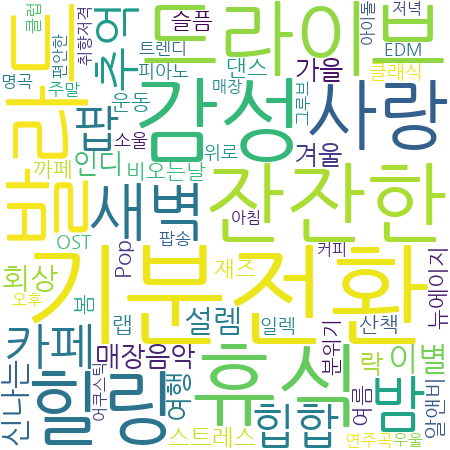

In [144]:
# 태그 별 매핑 빈도 수 저장 
tag_cnt = plylst_tag_map.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['tags'], tag_cnt['mapping_cnt']))

# plotting
wc = WordCloud(font_path = './res/NanumGothic.ttf', background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

In [148]:
tag_list_plylst_cnt

,tag_list,plylst_cnt
51670,['발라드'],5497
58918,['팝'],3147
48836,['락'],2977
48990,"['랩', '힙합']",2550
45955,['댄스'],1558
57795,['일렉'],1499
44413,['뉴에이지'],1409
54748,"['소울', '알앤비']",1250
40318,"['기분전환', '휴식', '힐링']",950
52019,"['밤', '새벽', '잔잔한']",926


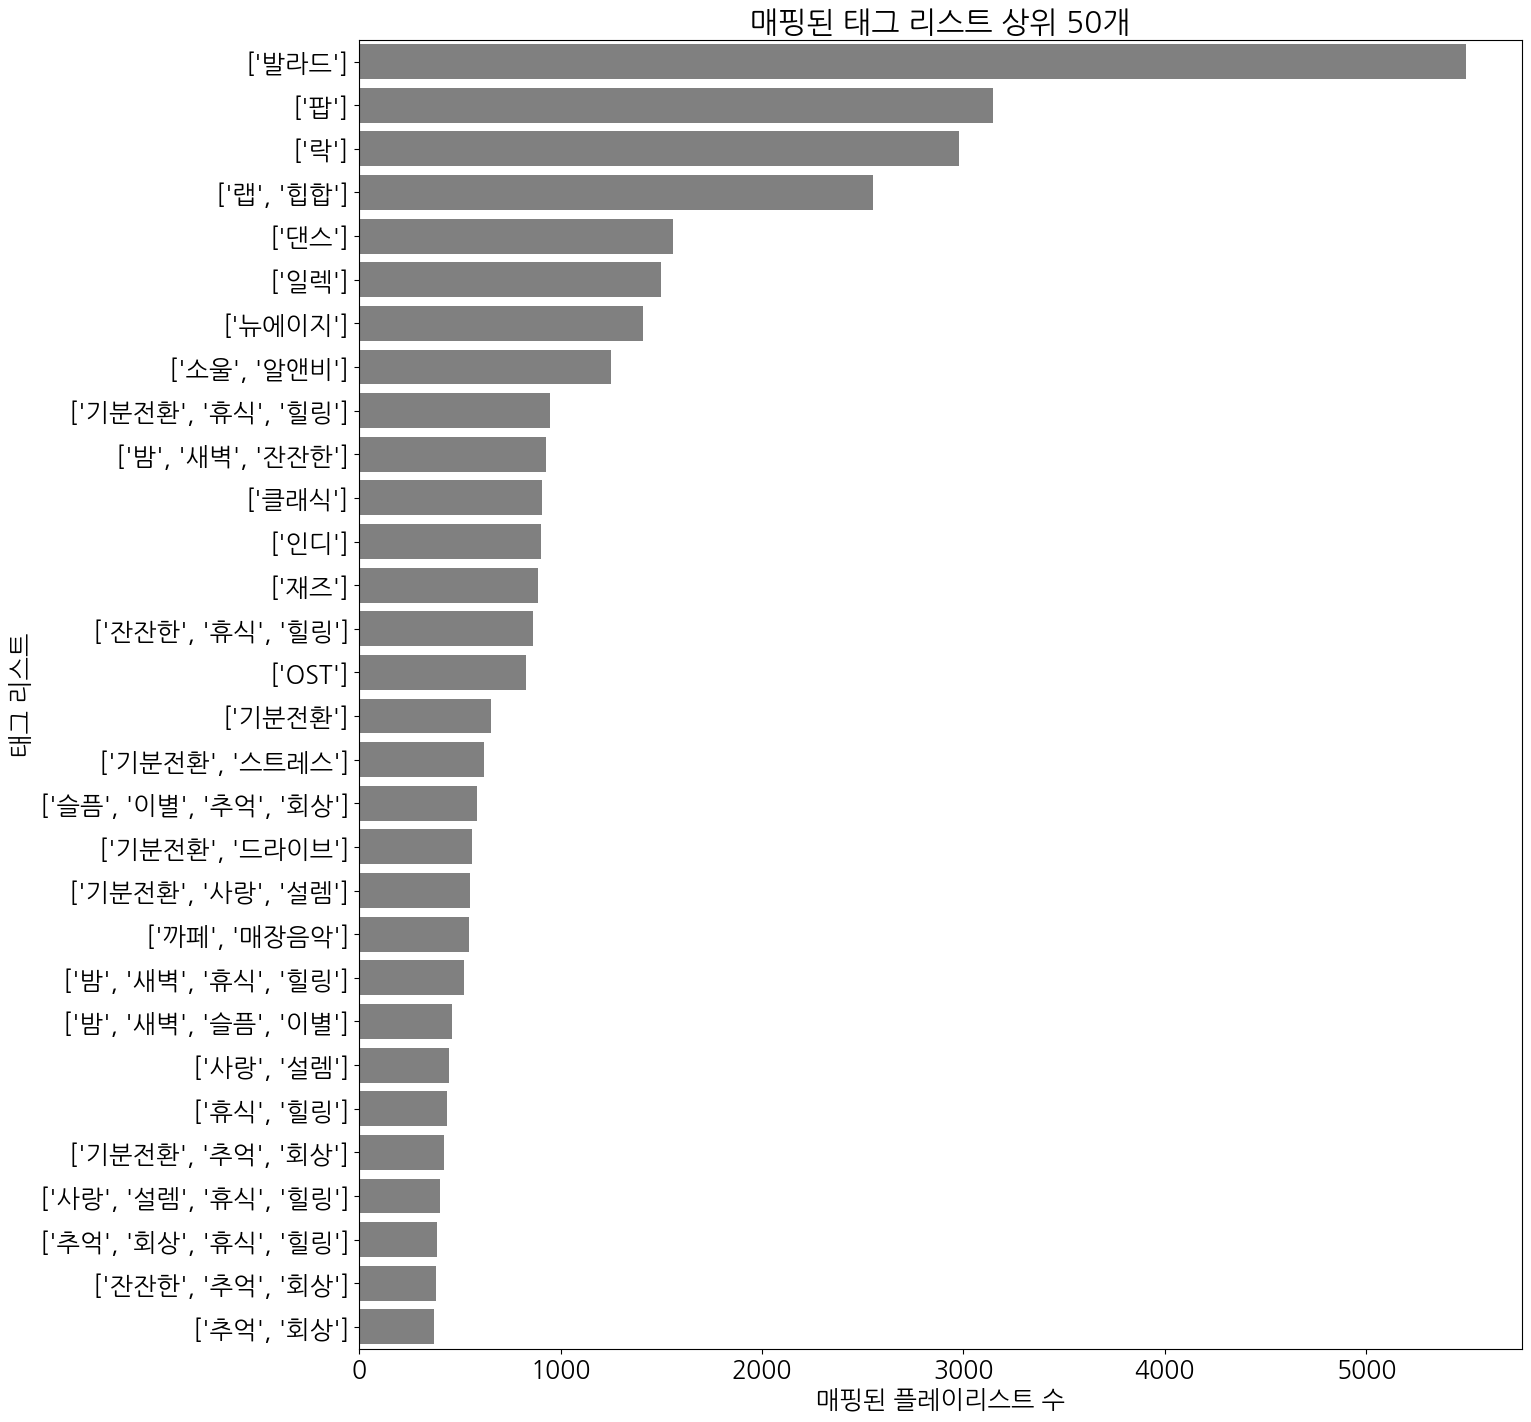

In [151]:
# 1. unnest 데이터프레임인 plylst_tag_map 테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 50개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(30, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (15, 17))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt, color = 'grey')
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 50개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

In [155]:
# 1. 플레이리스트-곡 테이블 plylst_song_map + 플레이리스트-태그 테이블 plylst_tag_map join 테이블 생성 : plylst_song_tag_map
plylst_song_tag_map = pd.merge(plylst_song_map, plylst_tag_map, how = 'left', on = 'id')

# 2. 1번 테이블 plylst_song_tag_map + 곡 장르 테이블 song_gnr_map join
plylst_song_tag_map = pd.merge(plylst_song_tag_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 2번 테이블에서 장르 메타 join
gnr_code['gnr_code_name'] = gnr_code['gnr_code'] + ' (' + gnr_code['gnr_name'] + ')'
gnr_code = gnr_code[['gnr_code', 'gnr_code_name']]
plylst_song_tag_map = pd.merge(plylst_song_tag_map, gnr_code, how = 'left', on = 'gnr_code')

# 4. 최종 테이블 필드 선택
plylst_song_tag_map = plylst_song_tag_map[['id', 'songs', 'tags', 'gnr_code_name']]

C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\2863581865.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnr_code['gnr_code_name'] = gnr_code['gnr_code'] + ' (' + gnr_code['gnr_name'] + ')'


In [157]:
# 태그 = ['드라이브', '스트레스', '기분전환']
song_tag_map_sample_1 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['드라이브', '스트레스', '기분전환']), :]
# 태그 = ['밤', '새벽', '잔잔한']
song_tag_map_sample_2 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['밤', '새벽', '잔잔한']), :]
# 태그 = ['사랑', '설렘']
song_tag_map_sample_3 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['사랑', '설렘']), :]
# 태그 = ['추억', '회상']
song_tag_map_sample_4 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['추억', '회상']), :]
# 태그 = ['슬픔', '이별']
song_tag_map_sample_5 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['슬픔', '이별']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_6 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['휴식', '힐링']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_7 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['카페', '매장음악']), :]

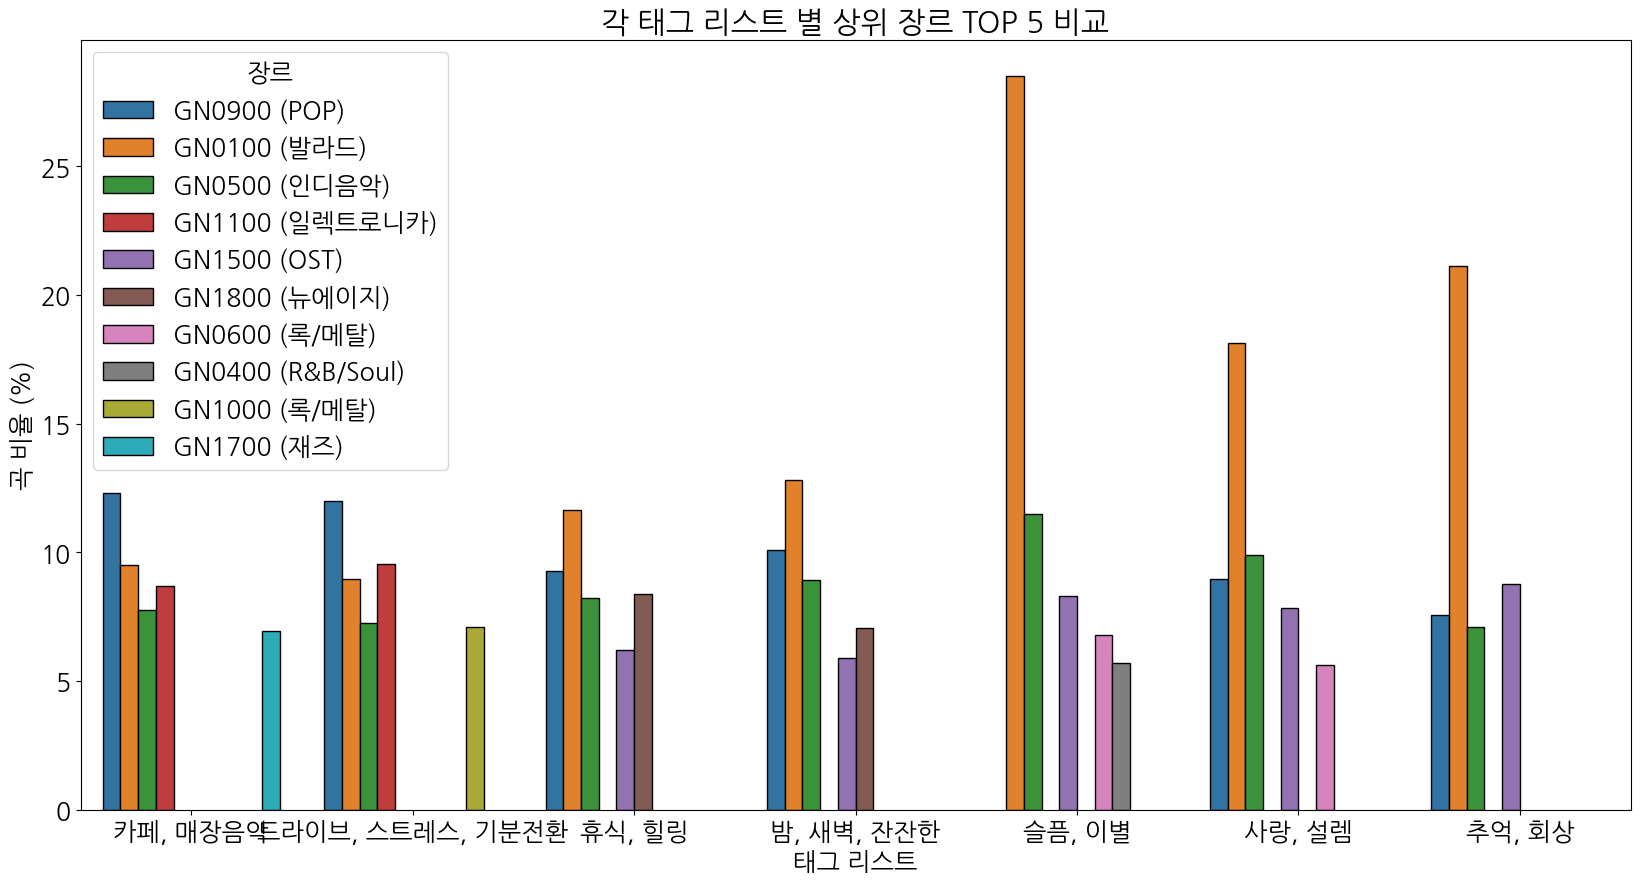

In [158]:
# 각 샘플 태그 리스트 별 장르 비율 집계
song_tag_map_sample_1_gnr_rank = song_tag_map_sample_1.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_1_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_1_gnr_rank['song_cnt']/sum(song_tag_map_sample_1_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_1_gnr_rank['gnr_rank'] = song_tag_map_sample_1_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_1_gnr_rank['tag_list'] = '드라이브, 스트레스, 기분전환'
song_tag_map_sample_1_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_2_gnr_rank = song_tag_map_sample_2.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_2_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_2_gnr_rank['song_cnt']/sum(song_tag_map_sample_2_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_2_gnr_rank['gnr_rank'] = song_tag_map_sample_2_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_2_gnr_rank['tag_list'] = '밤, 새벽, 잔잔한'
song_tag_map_sample_2_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_3_gnr_rank = song_tag_map_sample_3.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_3_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_3_gnr_rank['song_cnt']/sum(song_tag_map_sample_3_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_3_gnr_rank['gnr_rank'] = song_tag_map_sample_3_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_3_gnr_rank['tag_list'] = '사랑, 설렘'
song_tag_map_sample_3_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_4_gnr_rank = song_tag_map_sample_4.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_4_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_4_gnr_rank['song_cnt']/sum(song_tag_map_sample_4_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_4_gnr_rank['gnr_rank'] = song_tag_map_sample_4_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_4_gnr_rank['tag_list'] = '추억, 회상'
song_tag_map_sample_4_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_5_gnr_rank = song_tag_map_sample_5.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_5_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_5_gnr_rank['song_cnt']/sum(song_tag_map_sample_5_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_5_gnr_rank['gnr_rank'] = song_tag_map_sample_5_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_5_gnr_rank['tag_list'] = '슬픔, 이별'
song_tag_map_sample_5_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_6_gnr_rank = song_tag_map_sample_6.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_6_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_6_gnr_rank['song_cnt']/sum(song_tag_map_sample_6_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_6_gnr_rank['gnr_rank'] = song_tag_map_sample_6_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_6_gnr_rank['tag_list'] = '휴식, 힐링'
song_tag_map_sample_6_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_7_gnr_rank = song_tag_map_sample_7.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_7_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_7_gnr_rank['song_cnt']/sum(song_tag_map_sample_7_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_7_gnr_rank['gnr_rank'] = song_tag_map_sample_7_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_7_gnr_rank['tag_list'] = '카페, 매장음악'
song_tag_map_sample_7_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

# delete object
del song_tag_map_sample_1, song_tag_map_sample_2, song_tag_map_sample_3, song_tag_map_sample_4, song_tag_map_sample_5, song_tag_map_sample_6, song_tag_map_sample_7

# row binding
song_tag_map_sample_rbind = pd.concat(
    [song_tag_map_sample_1_gnr_rank, song_tag_map_sample_2_gnr_rank, song_tag_map_sample_3_gnr_rank,
     song_tag_map_sample_4_gnr_rank, song_tag_map_sample_5_gnr_rank, song_tag_map_sample_6_gnr_rank,
     song_tag_map_sample_7_gnr_rank],
    axis = 0
)

# plotting
song_tag_map_sample_rbind_plot = sns.barplot(
    data = song_tag_map_sample_rbind.loc[song_tag_map_sample_rbind['순위'] <= 5, :].sort_values(by = '순위'),
    x = '태그 리스트', y = '비율(%)', hue = '장르', edgecolor = "black"
)
song_tag_map_sample_rbind_plot.set_title('각 태그 리스트 별 상위 장르 TOP 5 비교')
song_tag_map_sample_rbind_plot.set_xlabel('태그 리스트')
song_tag_map_sample_rbind_plot.set_ylabel('곡 비율 (%)')
plt.show()

C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\101834773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plylst_song_tag_map_issue_year_filter['issue_year'] = plylst_song_tag_map_issue_year_filter['issue_year'].apply(pd.to_numeric)
C:\Users\cg063\AppData\Local\Temp\ipykernel_17168\101834773.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df['issue_year'], hist = False, kde = 

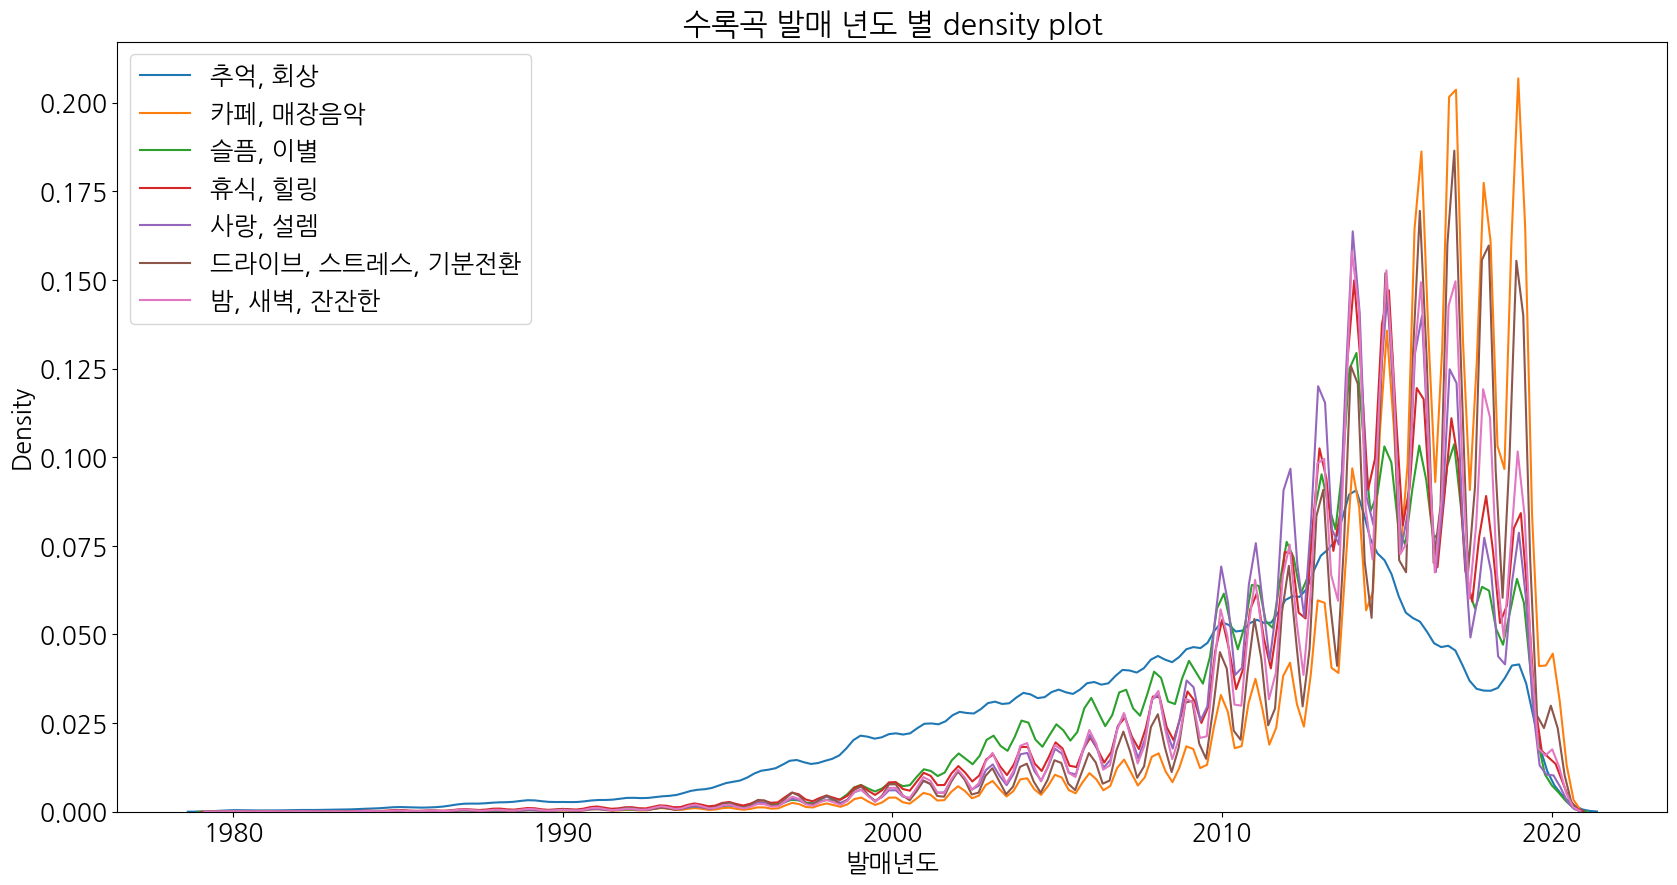

In [159]:
# 위에서 생성한 테이블에서 곡 별 발매년도 join
plylst_song_tag_map_issue_year = pd.merge(plylst_song_tag_map, song_issue_date, how = 'left', left_on = 'songs', right_on = 'song_id')

# 샘플 태그들이 포함되어 있는 플레이리스트만 필터링
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year.loc[plylst_song_tag_map_issue_year.tags.isin(['드라이브', '스트레스', '기분전환', '밤', '새벽', '잔잔한', '사랑', '설렘', '추억', '회상', '슬픔', '이별', '휴식', '힐링', '카페', '매장음악']), :]
plylst_song_tag_map_issue_year_filter['issue_year'] = plylst_song_tag_map_issue_year_filter['issue_year'].apply(pd.to_numeric)
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year_filter[plylst_song_tag_map_issue_year_filter['issue_year'] >= 1980]

del plylst_song_tag_map_issue_year

# plotting
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['추억', '회상']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '추억, 회상')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['카페', '매장음악']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '카페, 매장음악')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['슬픔', '이별']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '슬픔, 이별')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['휴식', '힐링']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '휴식, 힐링')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['사랑', '설렘']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '사랑, 설렘')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['드라이브', '스트레스', '기분전환']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '드라이브, 스트레스, 기분전환')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['밤', '새벽', '잔잔한']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '밤, 새벽, 잔잔한')
plt.legend(prop = {'size' : 18})
plt.title('수록곡 발매 년도 별 density plot')
plt.xlabel('발매년도')
plt.ylabel('Density')
plt.show()

In [160]:
plylst_song_tag_map 

,id,songs,tags,gnr_code_name
0,61281,525514,락,GN1400 (포크/블루스/컨트리)
1,61281,129701,락,GN0900 (POP)
2,61281,129701,락,GN1000 (록/메탈)
3,61281,383374,락,GN1000 (록/메탈)
4,61281,562083,락,GN0900 (POP)
...,...,...,...,...
29620344,100389,13759,팝송모음,GN1000 (록/메탈)
29620345,100389,154078,노래추천,GN1000 (록/메탈)
29620346,100389,154078,팝송추천,GN1000 (록/메탈)
29620347,100389,154078,팝송,GN1000 (록/메탈)


In [164]:
# 학습 데이터 내에서 가장 많은 태그가 매핑된 아이유 - 밤편지 (144663) 예시

# 13위 174749 헤이즈-비도 오고 그래서
example_song = plylst_song_tag_map[plylst_song_tag_map['songs'] == '174749']
example_song

,id,songs,tags,gnr_code_name
20658,28452,174749,런쥔,GN0400 (R&B/Soul)
20659,28452,174749,라디오,GN0400 (R&B/Soul)
32704,73145,174749,기분전환,GN0400 (R&B/Soul)
32705,73145,174749,휴식,GN0400 (R&B/Soul)
32706,73145,174749,느낌있는,GN0400 (R&B/Soul)
...,...,...,...,...
29582319,44994,174749,피쳐링,GN0400 (R&B/Soul)
29582320,44994,174749,그루브,GN0400 (R&B/Soul)
29603435,15976,174749,가을비,GN0400 (R&B/Soul)
29603436,15976,174749,가을,GN0400 (R&B/Soul)


In [162]:
# 곡 별 매핑되는 태그 수 집계 : song_tag_map_cnt
song_tag_map_cnt = plylst_song_tag_map.groupby('songs').tags.nunique().reset_index(name = 'tags_cnt')
round(song_tag_map_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags_cnt,1.0,2.0,7.0,17.86,15.0,1928.0,44.95


In [165]:
example_song.groupby(['songs', 'tags']).id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)

,songs,tags,mapping_plylst_cnt
143,174749,감성,542
589,174749,비오는날,381
1123,174749,카페,373
513,174749,발라드,373
387,174749,드라이브,311
...,...,...,...
512,174749,받습니다,1
516,174749,발라드추천,1
517,174749,발라드추천곡,1
518,174749,발라드힙합,1


In [166]:
example_temp = plylst_song_tag_map.loc[plylst_song_tag_map['tags'] == '감성', :].groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)
pd.merge(example_temp, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id').head(10)

,songs,mapping_plylst_cnt,id,song_name,artist_name_basket
0,357367,735,357367,비,[폴킴]
1,144663,690,144663,밤편지,[아이유]
2,519391,678,519391,Love Again,[김제훈]
3,640657,667,640657,내가 말하고 싶은건,[김제훈]
4,463173,662,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)]
5,349492,659,349492,어떤이별,[임승부]
6,427724,653,427724,지워줄게 (Vocal by 스티브언니),[아재]
7,680366,650,680366,끝내지 못한 이야기 (Feat. 호수),[어쿠스틱 멜로디 (Acoustic Melody)]
8,520093,641,520093,고마운 사람 (Vocal by 이소진),[업라이트 (Upright)]
9,215411,639,215411,지금보다 조금 (Feat. 이원),[어쿠스틱 멜로디 (Acoustic Melody)]
